# Setup + Data preparation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

In [23]:
regime_df = pd.read_csv('regime_prediction_RF_single_base_model.csv',index_col='Unnamed: 0', parse_dates=True) # predicted regime from stage 1
stage1_features_df = pd.read_csv('stage02_data.csv', index_col='Unnamed: 0', parse_dates=True) # macro-economics feature and true regime form stage 1
factor_returns_df = pd.read_csv('final_df.csv', index_col='Date', parse_dates=True) # ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol', 'RF'] factor return

print("shape:")
print(f"Regime predict: {regime_df.shape}")
print(f"Stage1: {stage1_features_df.shape}") 
print(f"factor return: {factor_returns_df.shape}")

print("\nRegime column:")
print(regime_df.columns.tolist())
print("\nStage1 feature column:")
print(stage1_features_df.columns.tolist())
print("\nfactor return column:")
print(factor_returns_df.columns.tolist())

shape:
Regime predict: (307, 1)
Stage1: (308, 12)
factor return: (308, 7)

Regime column:
['regime_pred']

Stage1 feature column:
['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown', 'regime', 'real_gdp_growth_monthly', 'cpi_1y', 'cpi_10y']

factor return column:
['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol', 'RF']


In [4]:
def prepare_stage2_data(regime_df, stage1_features_df, factor_returns_df):
    """
    prepare all data need to use for stage 2
    """
    common_dates = regime_df.index.intersection(stage1_features_df.index).intersection(factor_returns_df.index)
    
    merged_data = pd.DataFrame(index=common_dates)
    
    merged_data['True_Regime'] = stage1_features_df.loc[common_dates, 'regime'] 
    merged_data['True_Regime'] = merged_data['True_Regime'].replace(2, 1)
    merged_data['Predicted_Regime'] = regime_df.loc[common_dates, 'regime_pred'] 
    
    feature_columns = ['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown', 'real_gdp_growth_monthly', 'cpi_1y', 'cpi_10y']
    for col in feature_columns:
        merged_data[col] = stage1_features_df.loc[common_dates, col]
    
    factor_columns = ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol']
    for col in factor_columns:
        merged_data[col] = factor_returns_df.loc[common_dates, col]
    
    print(f"merged data shape: {merged_data.shape}")
    print(f"time range: {merged_data.index.min()} to {merged_data.index.max()}")
    print(f"market regime - true:")
    print(merged_data['True_Regime'].value_counts().sort_index())
    print(f"market regime - predict:")
    print(merged_data['Predicted_Regime'].value_counts().sort_index())
    
    return merged_data

full_data = prepare_stage2_data(regime_df, stage1_features_df, factor_returns_df)

merged data shape: (306, 19)
time range: 2000-03-01 00:00:00 to 2025-08-01 00:00:00
market regime - true:
True_Regime
0    193
1    113
Name: count, dtype: int64
market regime - predict:
Predicted_Regime
0    179
1    127
Name: count, dtype: int64


# Predict Winning Factor (Expanding Rolling ML)

We predict the winning equity each month:
- Train seperate Random Forest classifiers within each true regime (from Stage 1)
- For live prediction, use predicted regime and assign portfolio weights based on predicted probabilities.
$$w_{i,t} = P(\text{factor $i$ wins at time $t$})$$

In [24]:
class FactorPerformancePredictor:
    """
    Stage 2 (Expanding Rolling ML)
    Train RF models under TRUE regime; predict weights using PREDICTED regime.
    """

    def __init__(self, factor_names):
        self.factor_names = factor_names

    def _create_factor_labels(self, factor_returns):
        """Binary label indicating which factor had best return each month."""
        valid = factor_returns[self.factor_names].dropna(how='all')
        best = valid.idxmax(axis=1)
        labels = pd.DataFrame({
            f: (best == f).astype(int).reindex(factor_returns.index).fillna(0)
            for f in self.factor_names
        }, index=factor_returns.index)
        return labels

    def _train_models_by_regime(self, X, y_labels, regimes):
        """Train regime-specific Random Forests."""
        models, scalers = {}, {}
        for r in sorted(regimes.dropna().unique()):
            mask = regimes == r
            X_reg, y_reg = X.loc[mask], y_labels.loc[mask]
            if X_reg.empty:
                continue
            X_reg = X_reg.ffill().bfill()

            scaler = StandardScaler()
            X_scaled = pd.DataFrame(
                scaler.fit_transform(X_reg),
                columns=X_reg.columns, index=X_reg.index
            )
            scalers[r] = scaler

            models[r] = {}
            for f in self.factor_names:
                y = y_reg[f].values
                if y.sum() == 0:
                    continue
                model = RandomForestClassifier(
                    n_estimators=200, max_depth=8,
                    class_weight='balanced', random_state=42
                )
                model.fit(X_scaled, y)
                models[r][f] = model

        return models, scalers

    def _predict_one_month(self, X_single, predicted_regime, models, scalers):
        """Return probability distribution (= portfolio weights)."""
        if predicted_regime not in models:
            return {f: 1 / len(self.factor_names) for f in self.factor_names}

        scaler = scalers[predicted_regime]
        X_scaled = pd.DataFrame(
            scaler.transform(X_single),
            columns=X_single.columns, index=X_single.index
        )

        probs = {}
        for f in self.factor_names:
            probs[f] = models[predicted_regime][f].predict_proba(X_scaled)[0, 1] \
                       if f in models[predicted_regime] else 0.0

        s = sum(probs.values())
        return {k: v / s if s > 0 else 1 / len(self.factor_names) for k, v in probs.items()}

    def expanding_predict(self, full_data, factor_cols, feature_cols, start_train_idx=240):
        """Rolling expanding ML training + prediction."""
        labels = self._create_factor_labels(full_data[factor_cols])
        records = []

        for t in range(start_train_idx, len(full_data)):
            train = full_data.iloc[:t]
            test = full_data.iloc[[t]]
            date = full_data.index[t]

            X_train = train[feature_cols]
            y_train = labels.iloc[:t]
            true_regime = train["True_Regime"]

            models, scalers = self._train_models_by_regime(X_train, y_train, true_regime)

            pred_regime = test["Predicted_Regime"].iloc[0]
            probs = self._predict_one_month(test[feature_cols], pred_regime, models, scalers)

            probs["Predicted_Regime"] = pred_regime
            probs["True_Regime"] = test["True_Regime"].iloc[0]
            probs["Date"] = date

        prob_df = pd.DataFrame(records).set_index("Date")
        prob_df.columns = [f"Prob_{c}" if c in self.factor_names else c for c in prob_df.columns]
        return prob_df

In [6]:
factor_cols = ['Value', 'Growth', 'Momentum', 'Quality', 'Small_Cap', 'Low_Vol']
feature_cols =['financial_turbulence', 'nfc_risk', 'nfc_credit', 'nfc_leverage', 
               'TR CAPE', 'effr', 't3m effr spread', 'sp_3m_drawdown', 'real_gdp_growth_monthly', 'cpi_1y', 'cpi_10y']

predictor = FactorPerformancePredictor(factor_cols)
rolling_probs = predictor.expanding_predict(full_data, factor_cols, feature_cols, start_train_idx=240)

Trained up to 2020-03-01
Trained up to 2021-03-01
Trained up to 2022-03-01
Trained up to 2023-03-01
Trained up to 2024-03-01
Trained up to 2025-03-01


In [7]:
def calculate_factor_accuracy(true_returns, rolling_probs, factor_cols):
    """
    Evaluate factor prediction accuracy from rolling_probs output
    Inputs:
        true_returns : full_data[factor_cols]
        rolling_probs : output from predictor.expanding_predict()
        factor_cols : list of factor names used in Stage2
    Output:
        dict of per-factor accuracy + predicted count
        float overall accuracy
    """

    results = {f: {"correct": 0, "predicted_count": 0} for f in factor_cols}
    total_correct = 0
    total_periods = len(rolling_probs)

    # iterate by date
    for dt in rolling_probs.index:
        pred_prob_row = rolling_probs.loc[dt]

        predicted_winner = pred_prob_row[[f"Prob_{f}" for f in factor_cols]].idxmax() # Predicted Winner
        predicted_winner = predicted_winner.replace("Prob_", "") 

        true_winner = true_returns.loc[dt].idxmax()

        results[predicted_winner]["predicted_count"] += 1

        # Compare
        if predicted_winner == true_winner:
            results[predicted_winner]["correct"] += 1
            total_correct += 1

    # compute accuracy per factor
    for f in factor_cols:
        pred_cnt = results[f]["predicted_count"]
        results[f]["accuracy"] = results[f]["correct"] / pred_cnt if pred_cnt > 0 else 0.0

    overall_accuracy = total_correct / total_periods if total_periods > 0 else 0.0

    return results, overall_accuracy


In [8]:
true_returns = full_data[factor_cols]

accuracy_results, overall_accuracy = calculate_factor_accuracy(
    true_returns=true_returns,
    rolling_probs=rolling_probs,
    factor_cols=factor_cols
)

In [9]:
# actual winning frequency (for reference / compare baseline)
actual_win_pct = {}
for f in factor_cols:
    actual_win_pct[f] = sum(true_returns.idxmax(axis=1) == f) / len(true_returns)


print("\n" + "="*60)
print("FACTOR PREDICTION ACCURACY (Stage 2)")
print("="*60)

print(f"\n{'Factor':<12} {'Accuracy':<10} {'Pred Count':<12} {'Actual Win %':<10}")
print("-"*60)

for f in factor_cols:
    acc = accuracy_results[f]['accuracy']
    pc = accuracy_results[f]['predicted_count']
    aw = actual_win_pct[f]
    print(f"{f:<12} {acc:>7.3f}      {pc:>6d}         {aw:>7.3f}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Overall Accuracy:  {overall_accuracy:.3f}")
print(f"Random Baseline:   {1/len(factor_cols):.3f}")



FACTOR PREDICTION ACCURACY (Stage 2)

Factor       Accuracy   Pred Count   Actual Win %
------------------------------------------------------------
Value          0.556           9           0.118
Growth         0.429          28           0.363
Momentum       0.267          15           0.206
Quality        0.273          11           0.127
Small_Cap      0.000           1           0.052
Low_Vol        0.500           2           0.134

SUMMARY
Overall Accuracy:  0.379
Random Baseline:   0.167


# Backtest Based on Predicted Probabilities

We evaluate whether ML-based factor timing improves performance vs. equal-weight benchmark.

In [25]:
def _max_drawdown_from_values(values):
    """Return maximum drawdown (positive number)."""
    s = pd.Series(values).reset_index(drop=True)
    drawdown = (s - s.cummax()) / s.cummax()
    return -drawdown.min()


def _annualize_return(end_value, start_value, periods, periods_per_year=12):
    """Annualized return from cumulative growth."""
    if periods <= 0:
        return 0.0
    return (end_value / start_value) ** (periods_per_year / periods) - 1


def compute_metrics(returns_series, value_series, initial_capital=1.0):
    """
    Calculate key performance metrics:
      total return, annualized return, volatility, Sharpe, MDD, win rate.
    """
    n_periods = len(returns_series)
    if n_periods == 0:
        return {k: 0.0 for k in
                ["total_return","annualized_return","annualized_volatility","sharpe_ratio","max_drawdown","win_rate"]}

    end_value = float(value_series[-1])
    total_return = end_value / initial_capital - 1
    ann_ret = _annualize_return(end_value, initial_capital, n_periods)

    vol_ann = returns_series.std(ddof=0) * np.sqrt(12)
    sharpe = (returns_series.mean() * 12) / vol_ann if vol_ann != 0 else 0.0

    mdd = _max_drawdown_from_values(value_series)
    win_rate = (returns_series > 0).sum() / n_periods

    return {
        "total_return": total_return,
        "annualized_return": ann_ret,
        "annualized_volatility": vol_ann,
        "sharpe_ratio": sharpe,
        "max_drawdown": mdd,
        "win_rate": win_rate
    }


def backtest_with_probs_and_baseline(full_data, factor_cols, rolling_probs,
                                     initial_capital=1.0, returns_in_percent=True,
                                     print_summary=True):
    """
    Backtest ML factor timing vs. equal-weight benchmark.
      - ML weights = rolling_probs
      - EW = equal allocation across factors
    """
    # align probabilities with factor return columns
    probs = rolling_probs[[f"Prob_{f}" for f in factor_cols]].copy()
    probs.columns = factor_cols

    # factor returns for same dates
    rets = full_data.loc[probs.index, factor_cols].copy()
    if returns_in_percent:
        rets = rets / 100.0   # convert e.g., 10 => 10% return

    ml_values = [initial_capital]
    ew_values = [initial_capital]
    ml_returns, ew_returns, weight_history = [], [], []

    for i in range(len(rets)):
        w = probs.iloc[i].values.astype(float)
        w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / len(w)

        f_ret = rets.iloc[i].values.astype(float)

        ml_ret = float(np.dot(w, f_ret))       # ML weighted return
        ew_ret = float(np.mean(f_ret))         # equal-weight baseline

        ml_returns.append(ml_ret)
        ew_returns.append(ew_ret)
        weight_history.append(w)

        ml_values.append(ml_values[-1] * (1 + ml_ret))
        ew_values.append(ew_values[-1] * (1 + ew_ret))

    # result dataframe
    results_df = pd.DataFrame(index=rets.index)
    results_df["Portfolio_Return_ML"] = ml_returns
    results_df["Portfolio_Value_ML"] = ml_values[1:]
    results_df["Portfolio_Return_EW"] = ew_returns
    results_df["Portfolio_Value_EW"] = ew_values[1:]

    # save weights
    for idx, f in enumerate(factor_cols):
        results_df[f"Weight_{f}"] = [w[idx] for w in weight_history]

    metrics_ml = compute_metrics(pd.Series(ml_returns, index=rets.index), ml_values[1:], initial_capital)
    metrics_ew = compute_metrics(pd.Series(ew_returns, index=rets.index), ew_values[1:], initial_capital)

    metrics = {"ML": metrics_ml, "Equal_Weight": metrics_ew}

    if print_summary:
        print("=== BACKTEST SUMMARY ===")
        print(f"Period: {results_df.index[0].date()} → {results_df.index[-1].date()}  ({len(rets)} months)")
        print("\nML Strategy:")
        for k, v in metrics_ml.items():
            print(f"  {k:22s}: {v:.4f}")
        print("\nEqual-Weight Strategy:")
        for k, v in metrics_ew.items():
            print(f"  {k:22s}: {v:.4f}")

    return {
        "results_df": results_df,
        "metrics": metrics,
        "portfolio_series": {
            "ML": ml_values[1:], "Equal_Weight": ew_values[1:]
        },
        "weights": pd.DataFrame([dict(zip(factor_cols, w)) for w in weight_history], index=rets.index)
    }

In [12]:
out = backtest_with_probs_and_baseline(
    full_data=full_data,
    factor_cols=factor_cols,
    rolling_probs=rolling_probs,
    initial_capital=1.0,
    returns_in_percent=True,
    print_summary=True
)

df_results = out['results_df']
metrics = out['metrics']

=== BACKTEST SUMMARY ===
Period: 2020-03-01 → 2025-08-01  (66 months)

ML Strategy:
  total_return          : 0.5400
  annualized_return     : 0.0817
  annualized_volatility : 0.0876
  sharpe_ratio          : 0.9429
  max_drawdown          : 0.0891
  win_rate              : 0.6364

Equal-Weight Strategy:
  total_return          : 0.3943
  annualized_return     : 0.0623
  annualized_volatility : 0.0732
  sharpe_ratio          : 0.8649
  max_drawdown          : 0.0706
  win_rate              : 0.5455


# Visualization

1. cross-correlation heatmap by regime

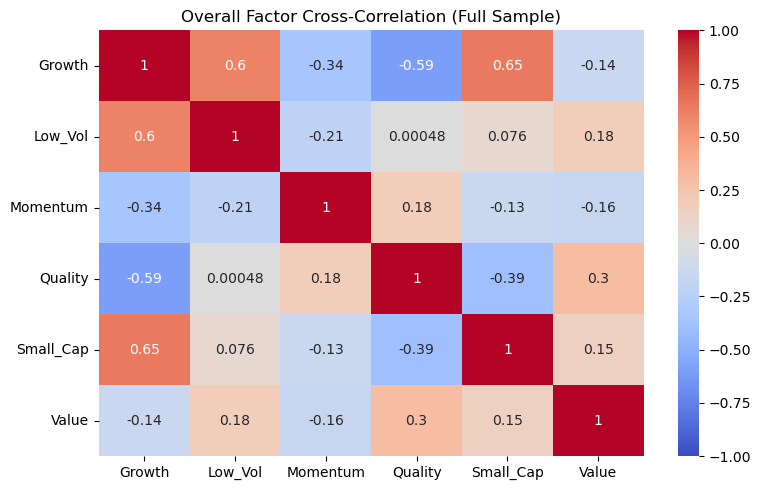

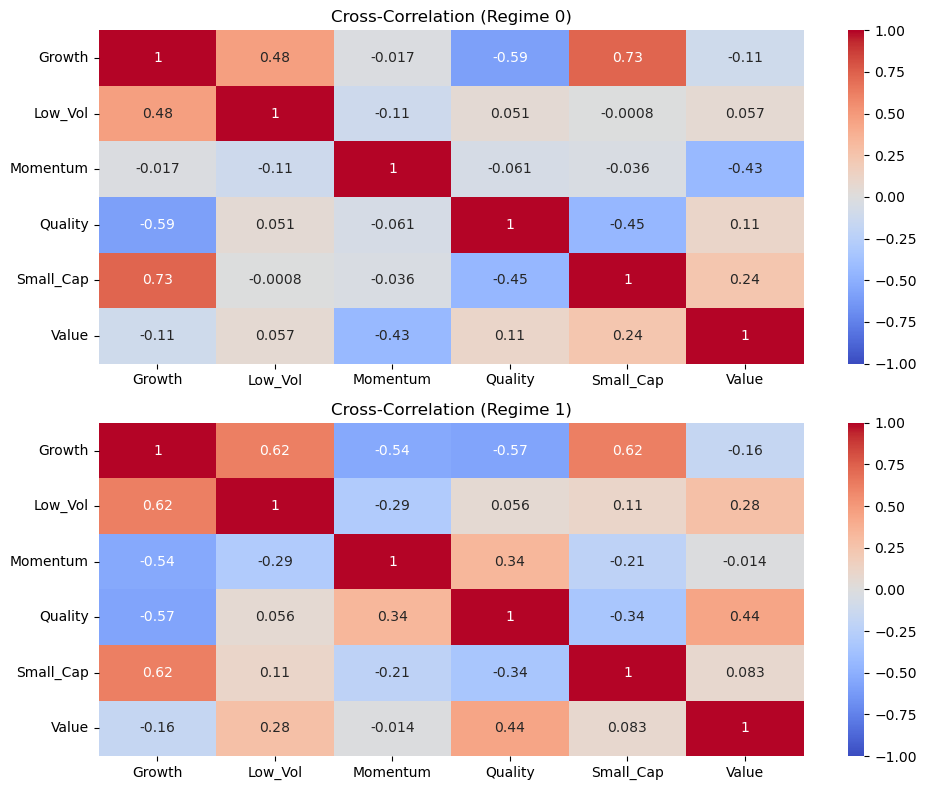

In [33]:
def plot_correlation_by_regime(full_data, factor_cols):
    regimes = sorted(full_data["True_Regime"].dropna().unique())

    overall_corr = full_data[factor_cols].corr() # Overall Correlation Heatmap (Whole Dataset)

    plt.figure(figsize=(8,5))
    sns.heatmap(
        overall_corr,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1
    )
    plt.title("Overall Factor Cross-Correlation (Full Sample)")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(regimes), 1, figsize=(10, 4 * len(regimes))) #Heatmap by Regime

    for i, regime in enumerate(regimes):
        regime_df = full_data[full_data["True_Regime"] == regime][factor_cols]
        corr = regime_df.corr()

        sns.heatmap(
            corr,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            ax=axes[i] if len(regimes) > 1 else axes
        )
        axes[i].set_title(f"Cross-Correlation (Regime {regime})")

    plt.tight_layout()
    plt.show()

plot_correlation_by_regime(full_data, factor_cols)

2. Stacked Probability Chart

<Figure size 1400x600 with 0 Axes>

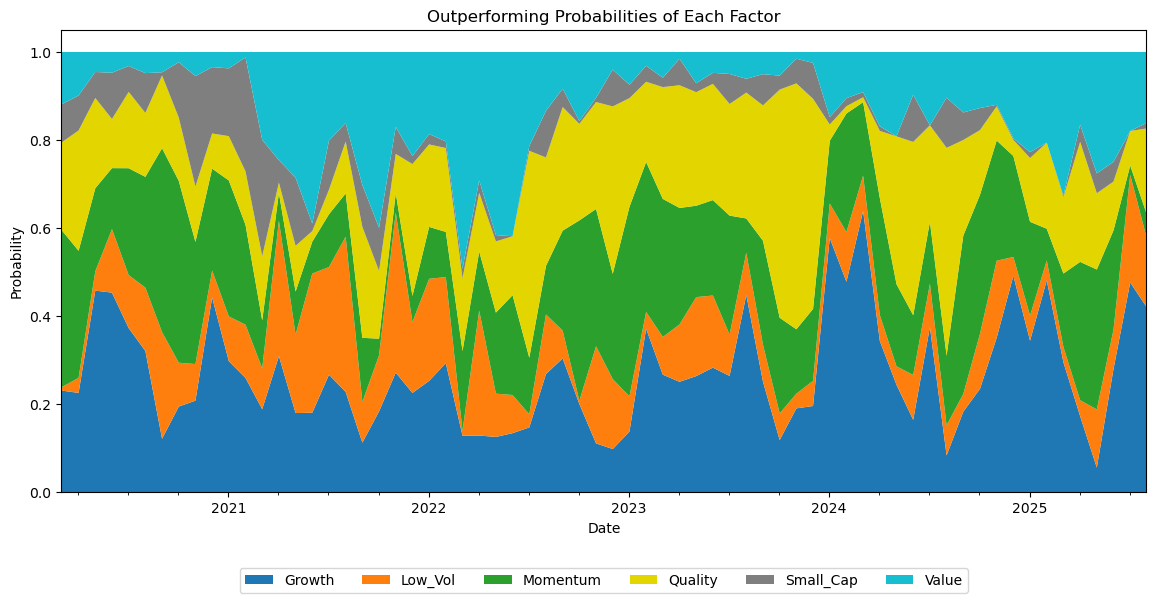

In [35]:
plt.figure(figsize=(14,6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#e2d500", "#7f7f7f", "#17becf"]

prob_cols = {f"Prob_{f}": f for f in factor_cols}
probs = rolling_probs.rename(columns=prob_cols)

probs[factor_cols].plot.area(
    stacked=True,
    figsize=(14,6),
    color=colors,
    linewidth=0
)

plt.title("Outperforming Probabilities of Each Factor")
plt.ylabel("Probability")
plt.legend(loc="upper center", ncol=6, bbox_to_anchor=(0.5, -0.15))
plt.show()

3. cumilative return: ML vs Equal Weight

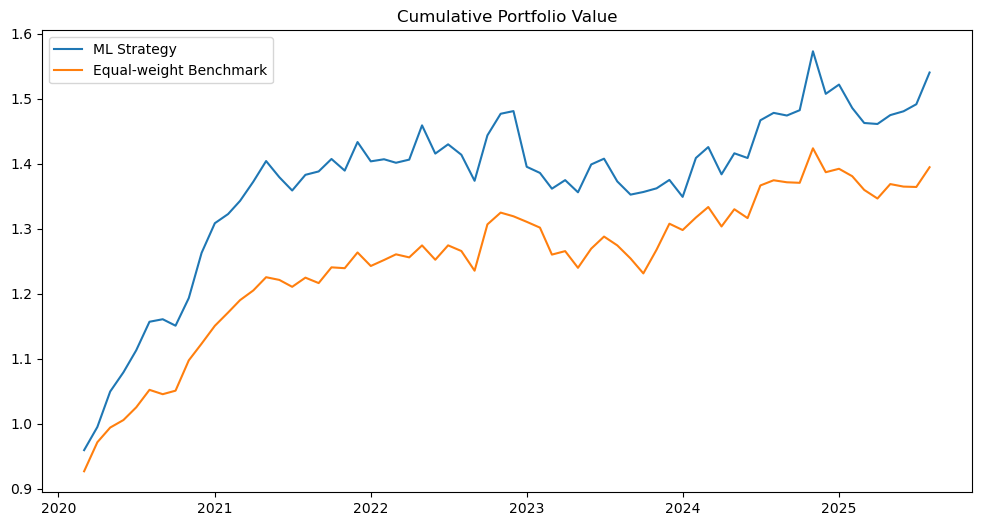

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results["Portfolio_Value_ML"], label="ML Strategy")
plt.plot(df_results.index, df_results["Portfolio_Value_EW"], label="Equal-weight Benchmark")
plt.title("Cumulative Portfolio Value")
plt.legend()
plt.show()

4. Allocation Heatmap (factor probability as weights)

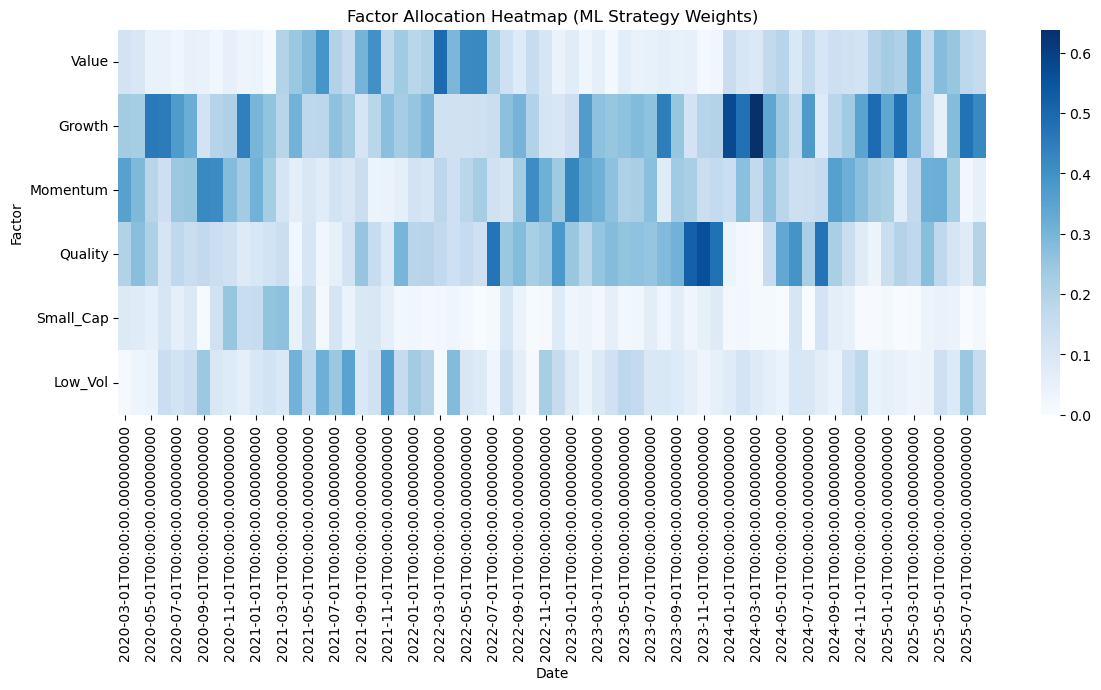

In [30]:
weights_df = out["weights"] 

plt.figure(figsize=(14, 5))
sns.heatmap(weights_df.T, cmap="Blues", cbar=True)
plt.title("Factor Allocation Heatmap (ML Strategy Weights)")
plt.xlabel("Date")
plt.ylabel("Factor")
plt.show()

5. Exhibit 15 — Business Cycle Strategy

In [43]:
def compute_business_cycle_factor_stats(full_data, factor_cols, cycle_label="True_Regime"):
    """
    Average factor performance in each regime.
    """

    cycle_stats = (
        full_data.groupby(cycle_label)[factor_cols]
        .mean()                         
        .rank(axis=1, ascending=False) 
    )

    return cycle_stats

cycle_stats = compute_business_cycle_factor_stats(full_data, factor_cols)

plus_mask = (cycle_stats == 1) | (cycle_stats == 2)
minus_mask = (cycle_stats == 5) | (cycle_stats == 6)

exhibit5 = pd.DataFrame("", index=cycle_stats.index, columns=cycle_stats.columns)
exhibit5[plus_mask] = "+"
exhibit5[minus_mask] = "-"
exhibit5

,Growth,Low_Vol,Momentum,Quality,Small_Cap,Value
True_Regime,,,,,,
0,+,+,,-,,-
1,-,-,,+,,+
